In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
import talib as ta
import json
import plotly.express as px
from typing import Callable, Any

In [25]:
ticker = "PETR4.SA" 
start_train, end_train = ("2012-01-01", "2017-12-31")
start_test, end_test = ("2018-01-01", "2023-12-31")

In [26]:
df = yf.download(ticker, start_train, end_test)
df["Returns"] = df["Adj Close"].pct_change(1)
df["Adj Low"] = df["Low"] - (df["Close"]-df["Adj Close"])
df["Adj High"] = df["High"] - (df["Close"]-df["Adj Close"])
df["Adj Open"] = df["Open"] - (df["Close"]-df["Adj Close"])

[*********************100%%**********************]  1 of 1 completed


In [27]:
df.dropna(axis = 0, inplace = True) 

In [28]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Returns,Adj Low,Adj High,Adj Open
count,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2.976000e+03,2976.000000,2976.000000,2976.000000,2976.000000
mean,20.777134,21.097218,20.440948,20.760880,9.167708,5.554666e+07,0.001031,8.847775,9.504045,9.183961
std,7.334761,7.412367,7.262621,7.346574,6.799977,3.598575e+07,0.029927,6.728131,6.854326,6.788709
min,4.200000,4.270000,4.120000,4.200000,1.434107,0.000000e+00,-0.296978,1.150446,1.484351,1.210446
25%,15.472500,15.680000,15.140000,15.417500,5.188794,3.319585e+07,-0.014302,4.938126,5.444204,5.186741
50%,20.350000,20.675000,20.010000,20.340000,6.806663,4.876155e+07,0.000809,6.517498,7.148605,6.848084
75%,26.690001,27.020000,26.260000,26.700001,10.271132,6.890132e+07,0.016009,9.921967,10.703921,10.331441
max,38.689999,38.860001,37.919998,38.520000,37.360001,6.989506e+08,0.222222,37.130001,37.459522,37.320000


In [29]:
df["Target"] = df["Returns"].shift(-1)
df["Target_cat"] = np.where(df["Target"] > 0, 1, 0)

In [30]:
df["Vol"] = df["Returns"].rolling(20).std()

In [31]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Returns,Adj Low,Adj High,Adj Open,Target,Target_cat,Vol
Date,,,,,,,,,,,,,
2023-12-21,36.669998,36.680000,36.070000,36.389999,36.389999,30511900,0.000275,36.070000,36.680000,36.669998,0.009618,1,0.015541
2023-12-22,36.500000,36.799999,36.369999,36.740002,36.740002,31234700,0.009618,36.369999,36.799999,36.500000,0.016059,1,0.015637
2023-12-26,36.860001,37.369999,36.830002,37.330002,37.330002,23466800,0.016059,36.830002,37.369999,36.860001,0.000804,1,0.015819
2023-12-27,37.320000,37.430000,37.130001,37.360001,37.360001,19588500,0.000804,37.130001,37.430000,37.320000,-0.003212,0,0.015575
2023-12-28,37.230000,37.360001,37.040001,37.240002,37.240002,21421900,-0.003212,37.040001,37.360001,37.230000,NaN,0,0.015343


In [32]:
print(json.dumps(ta.get_function_groups(), sort_keys = True, indent = 4))

{
    "Cycle Indicators": [
        "HT_DCPERIOD",
        "HT_DCPHASE",
        "HT_PHASOR",
        "HT_SINE",
        "HT_TRENDMODE"
    ],
    "Math Operators": [
        "ADD",
        "DIV",
        "MAX",
        "MAXINDEX",
        "MIN",
        "MININDEX",
        "MINMAX",
        "MINMAXINDEX",
        "MULT",
        "SUB",
        "SUM"
    ],
    "Math Transform": [
        "ACOS",
        "ASIN",
        "ATAN",
        "CEIL",
        "COS",
        "COSH",
        "EXP",
        "FLOOR",
        "LN",
        "LOG10",
        "SIN",
        "SINH",
        "SQRT",
        "TAN",
        "TANH"
    ],
    "Momentum Indicators": [
        "ADX",
        "ADXR",
        "APO",
        "AROON",
        "AROONOSC",
        "BOP",
        "CCI",
        "CMO",
        "DX",
        "MACD",
        "MACDEXT",
        "MACDFIX",
        "MFI",
        "MINUS_DI",
        "MINUS_DM",
        "MOM",
        "PLUS_DI",
        "PLUS_DM",
        "PPO",
        "ROC",
        "RO

In [33]:
def apply_pattern(df: pd.DataFrame, pattern: Callable[[Any, Any, Any, Any], Any]) -> None:
    name = pattern.__name__
    df[name] = pattern(df["Adj Open"], df["Adj High"], df["Adj Low"], df["Adj Close"])
    df[name] = np.where(df[name] == 100, 1, np.where(df[name] == -100, -1, 0))

In [34]:
patterns = [ta.CDLDOJISTAR, ta.CDLHARAMI, ta.CDLCLOSINGMARUBOZU, ta.CDLENGULFING, ta.CDLHAMMER]
pattern_names = [pattern.__name__ for pattern in patterns]

In [35]:
for pattern in patterns:
    apply_pattern(df, pattern)

In [36]:
features = pattern_names + ["Vol"]

In [37]:
fig = px.scatter(x = df[df["CDLDOJISTAR"] != 0]["Returns"]*100
                 , y = df[df["CDLDOJISTAR"] != 0]["Target"]*100 , trendline = "ols")

fig.update_layout(height = 600, width = 700
                  , title_text = "Doji Star x Target Returns"
                  , font_color = "blue"
                  , title_font_color = "black"
                  , xaxis_title = "Doji Returns"
                  , yaxis_title = "Target"
                  , font = dict(size = 15, color = "Black")
                  , showlegend = True
                 )

fig.show()

In [38]:
filtered_dfs = []

for pattern in pattern_names:
    filtered_df = df[df[pattern] != 0].dropna()
    filtered_dfs.append(filtered_df)

df_patterns = pd.concat(filtered_dfs).dropna()

target = "Target_cat"
columns_to_keep = [target, "Target"] + features
df_patterns = df_patterns[columns_to_keep].sort_index()

In [39]:
df_patterns.head()

,Target_cat,Target,CDLDOJISTAR,CDLHARAMI,CDLCLOSINGMARUBOZU,CDLENGULFING,CDLHAMMER,Vol
Date,,,,,,,,
2012-02-07,0,-0.006641,0,0,1,0,0,0.015522
2012-02-10,0,0.000000,0,0,-1,-1,0,0.024439
2012-02-10,0,0.000000,0,0,-1,-1,0,0.024439
2012-02-14,0,-0.004739,0,0,0,-1,0,0.023886
2012-02-16,1,0.007119,0,0,1,0,0,0.024143


In [40]:
# Filter data based on periods
df_train = df_patterns.loc[start_train:end_train]
df_test = df_patterns.loc[start_test:end_test]

columns_to_drop = [target, "Target"]

# Separate features (x) and target (y) for training and testing
x_train, y_train = df_train.drop(columns_to_drop, axis=1), df_train[target]
x_test, y_test = df_test.drop(columns_to_drop, axis=1), df_test[target]

In [41]:
print(x_train.shape)
print(x_test.shape)

(584, 6)
(567, 6)


In [42]:
from sklearn.ensemble import GradientBoostingClassifier
classifier = GradientBoostingClassifier(random_state=42, n_estimators=50, learning_rate=0.1, max_depth=1, loss="exponential")

model = classifier.fit(x_train, y_train)
model.score(x_test, y_test)

0.5485008818342152

In [43]:
# Define operational cost
op_cost = 0.0001 

#0.1% - R$2 reais em R$20000, assumindo operação completa - C/V
#Cada ponto de um mini contrato de índice: R$0.20 - Assumindo então o indice em média de 100k pontos

# Make predictions on the entire dataset
y_pred_all = model.predict(df_patterns.drop(columns_to_drop, axis=1))
df_patterns["Predicted"] = np.where(y_pred_all == 1, 1, -1)
df_patterns["Signal"] = np.sign(df_patterns["Predicted"])
df_patterns["Model_Returns"] = df_patterns["Signal"] * df_patterns["Target"] - op_cost

In [44]:
df_patterns.index.name = "Date"
df_patterns.reset_index(inplace=True)

df_patterns["Date"] = pd.to_datetime(df_patterns["Date"])

df_patterns["train_test"] = np.where(df_patterns["Date"] > end_train, "Test", "Train")

In [45]:
df_patterns.head()

,Date,Target_cat,Target,CDLDOJISTAR,CDLHARAMI,CDLCLOSINGMARUBOZU,CDLENGULFING,CDLHAMMER,Vol,Predicted,Signal,Model_Returns,train_test
0,2012-02-07,0,-0.006641,0,0,1,0,0,0.015522,-1,-1,0.006541,Train
1,2012-02-10,0,0.000000,0,0,-1,-1,0,0.024439,1,1,-0.000100,Train
2,2012-02-10,0,0.000000,0,0,-1,-1,0,0.024439,1,1,-0.000100,Train
3,2012-02-14,0,-0.004739,0,0,0,-1,0,0.023886,1,1,-0.004839,Train
4,2012-02-16,1,0.007119,0,0,1,0,0,0.024143,1,1,0.007019,Train


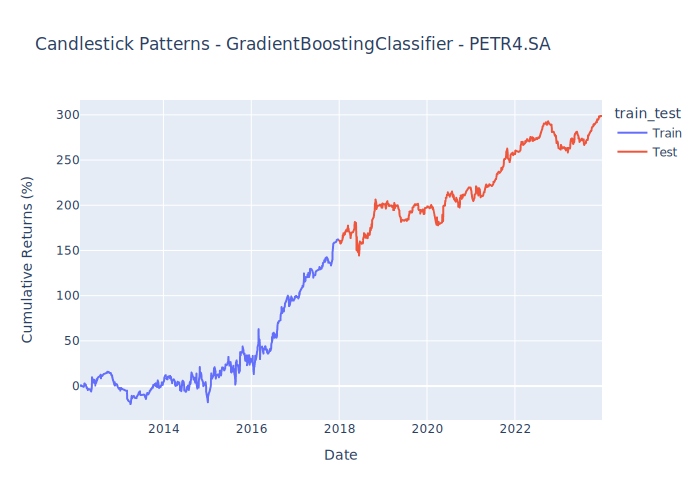

In [46]:
fig = px.line(df_patterns, x="Date", y=df_patterns["Model_Returns"].cumsum()*100, color="train_test",
              labels={"y": "Cumulative Returns (%)"},
              title=f"Candlestick Patterns - {model.__class__.__name__} - {ticker}",
              line_shape="linear")
fig.show("svg")